In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from matplotlib import gridspec

import numpy as np
from numpy import linalg

def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../src")   
add_relative_to_current_source_file_path_to_sys_path("../../logs")      

import spooky.coords
import log_graph
import replay.main

/Users/njoubert/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
LOG = "/Users/njoubert/Code/spooky/logs/state0001109.pickle"

'''
Setting up Tableau Colors. 
http://tableaufriction.blogspot.ca/2012/11/finally-you-can-use-tableau-data-colors.html
'''
t10 = np.array([[31,119,180],[255,127,14],[44,160,44],[214,39,40],[148,103,189]])
t10 = t10/255.0

t10l = np.array([[174,199,232],[255,187,120],[152,223,138],[255,152,150],[197,176,213]])
t10l = t10l/255.0

In [3]:
replay.main.generate_fake_SPP_GPS_Baselines

<function replay.main.generate_fake_SPP_GPS_Baselines>

In [4]:
l = log_graph.loadLog(LOG)

In [5]:

replay.main.reset_fake_calib()
for nextState in l:
    replay.main.generate_fake_SPP_GPS_Baselines(nextState,verbose=False)
    

In [32]:
errorNED = []
errorNE  = []
startTime = None
lastTime = 0
for nextState in l:
    if not startTime:
        startTime = nextState["_timestamp"]
    lastTime = nextState["_timestamp"]
    if "base_station" in nextState and "surveyed_pos" in nextState["base_station"]:
        for p in ['192.168.2.51','192.168.2.52']:
            person = nextState[p]
            real_baseline = np.array([float(person["MsgBaselineNED"]['n']), float(person["MsgBaselineNED"]['e']), float(person["MsgBaselineNED"]['d'])])
            calib_rel_ned = np.array([float(person["SPPGPSBaseline_calibrated"]['n']),float(person["SPPGPSBaseline_calibrated"]['e']),float(person["SPPGPSBaseline_calibrated"]['d'])])
            uncalib_rel_ned = np.array([float(person["SPPGPSBaseline"]['n']),float(person["SPPGPSBaseline"]['e']),float(person["SPPGPSBaseline"]['d'])])
            
            localError = linalg.norm(real_baseline - calib_rel_ned)
            errorNED.append([localError])
            localNEError = linalg.norm(real_baseline[0:1] - calib_rel_ned[0:1])
            errorNE.append([localNEError])
print errorNED            

[[0.0], [0.0], [27.923854766729615], [10.277972337694269], [36.793429358992221], [94.030977642850942], [33.889249236336077], [126.69909521805687], [45.165680093900775], [145.64028682140176], [57.553677038087997], [177.98941801270544], [68.597331621879476], [219.09398204571809], [70.639068526749156], [224.96708990012795], [69.732491127991693], [301.46457283501132], [69.732491127991693], [306.59263732897466], [71.229350122793988], [317.07141131980444], [79.928854170014034], [346.65583432109315], [81.65880432000921], [362.46913754345604], [97.98279597602415], [401.29365000375373], [97.722700600370644], [411.84136083315019], [102.1506421809451], [439.63752984964106], [101.04828662051115], [423.08001219588516], [111.38611222106233], [449.94734639068071], [106.42670321178863], [434.64397883397788], [124.25865701920637], [461.39213071080474], [124.91188349845457], [438.12733025687305], [120.79564281965045], [469.5003541274578], [117.48544182666159], [468.06608893669568], [122.72095490398104],

In [33]:
### GLOBAL_POSITION_INT CONTAINS THE RESULTING *FUSED* POSITION.
### THUS, THIS IS USING A NORMAL GPS ASSISTED WITH AN IMU AND BAROMETER

def get_errors_from_log(logname):
    l = log_graph.loadLog(logname)
    replay.main.reset_fake_calib()
    for nextState in l:
        replay.main.generate_fake_SPP_GPS_Baselines(nextState,verbose=False)

    errorNED = []
    errorNE  = []
    startTime = None
    lastTime = 0
    for nextState in l:
        if "base_station" in nextState and "surveyed_pos" in nextState["base_station"]:
            if not startTime:
                startTime = nextState["_timestamp"]
            lastTime = nextState["_timestamp"]
            for p in ['192.168.2.51','192.168.2.52']:
                person = nextState[p]
                if "MsgBaselineNED" in person and person["MsgBaselineNED"]["flags"] == 1:
                    
                    real_baseline = np.array([float(person["MsgBaselineNED"]['n']), float(person["MsgBaselineNED"]['e']), float(person["MsgBaselineNED"]['d'])])
                    calib_rel_ned = np.array([float(person["SPPGPSBaseline_calibrated"]['n']),float(person["SPPGPSBaseline_calibrated"]['e']),float(person["SPPGPSBaseline_calibrated"]['d'])])
                    uncalib_rel_ned = np.array([float(person["SPPGPSBaseline"]['n']),float(person["SPPGPSBaseline"]['e']),float(person["SPPGPSBaseline"]['d'])])

                    real_baseline = real_baseline / 1000.0
                    calib_rel_ned = calib_rel_ned / 1000.0
                    
                    localError = linalg.norm(real_baseline - calib_rel_ned)
                    errorNED.append([localError])
                    localNEError = linalg.norm(real_baseline[0:1] - calib_rel_ned[0:1])
                    errorNE.append([localNEError])
    return errorNE, errorNED, lastTime - startTime

In [47]:
loglist = [
    "/Users/njoubert/Code/spooky/logs/state0001091.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001094.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001099.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001101.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001102.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001103.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001105.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001106.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001109.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001110.pickle"
]

[0.0]
[0.0]
51
1000.54448318


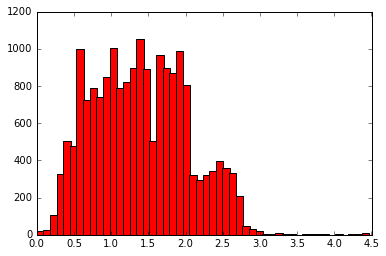

In [36]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001091.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
686.890803099


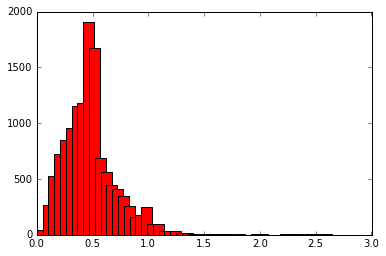

In [37]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001094.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
837.866279125


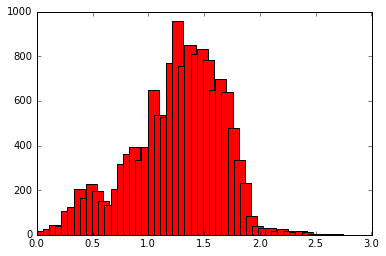

In [38]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001099.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
748.320538044


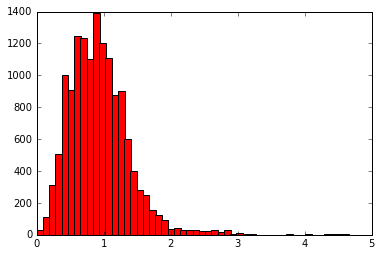

In [39]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001101.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
30.9852809906


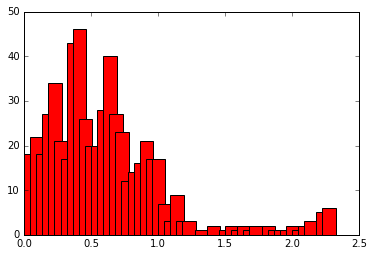

In [40]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001102.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
524.055351973


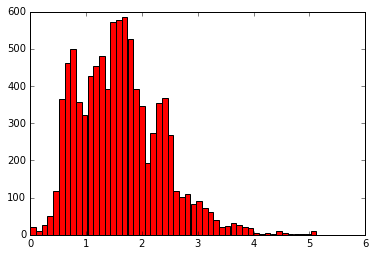

In [41]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001103.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
524.055351973


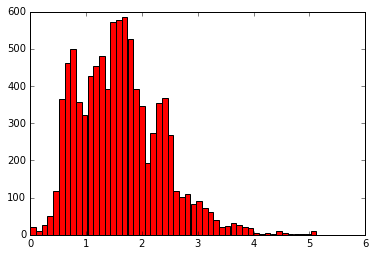

In [42]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001103.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
616.489763975


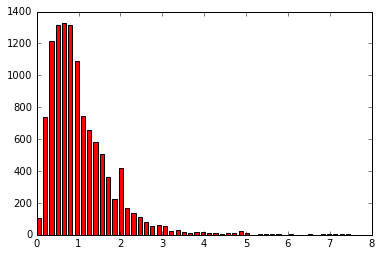

In [43]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001105.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
1158.86017394


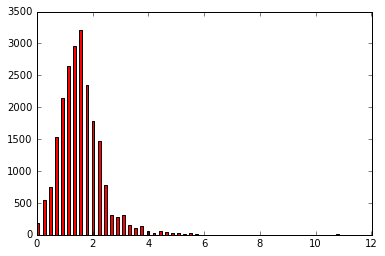

In [44]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001106.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
215.528002977
215.528002977


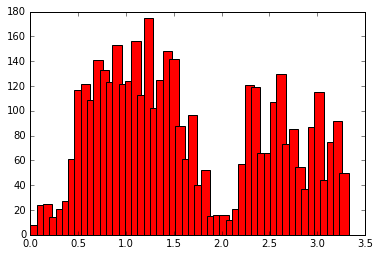

In [45]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001109.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength
print loglength

[0.0]
[0.0]
51
418.229232073


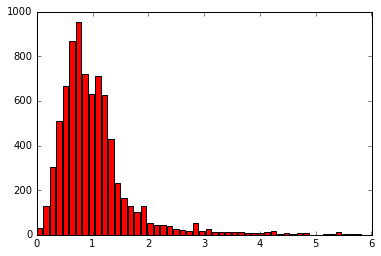

In [46]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001110.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=None)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

In [48]:
logresults = []
for l in loglist:
    errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001110.pickle")
    logresults.append((errorNE,errorNED,loglength))

In [49]:
logresults

[([[0.0],
   [0.0],
   [0.0080000000000000071],
   [0.0099999999999997868],
   [0.0080000000000000071],
   [0.0001318846322329037],
   [0.0060000000000002274],
   [0.0091318846322332448],
   [0.0038681161587339474],
   [0.0082637684734985228],
   [0.0038681161587339474],
   [0.014395653105730766],
   [0.0098681161587332866],
   [0.017395653105730879],
   [0.0098681161587332866],
   [0.0043956531057309789],
   [0.00039565310573230761],
   [0.028791307002431488],
   [0.006395653105732535],
   [0.021791307002431815],
   [0.0055275377379651047],
   [0.00779130700243158],
   [0.011527537737965332],
   [0.0089231916346648177],
   [0.0096594223701993442],
   [0.023055075475929776],
   [0.0096594223701993442],
   [0.034186960108163689],
   [0.0086594223701990103],
   [0.0071869601081635537],
   [0.02779130700243293],
   [0.02131884474039758],
   [0.022791307002433037],
   [0.018318844740397466],
   [0.018791307002433477],
   [0.02131884474039758],
   [0.022791307002433037],
   [0.0141869601081